# Entrofy Experiments

In order to test performance, we're going to run some basic experiments. 

Things we'd like to test:
* size of the target set
* size of the input set
* distance (targets versus source fractions)
* alpha
* n_trials
* perturbations.

Free variables are 
* the number of categories
* the number of attributes within each category
* the target fractions for each attribute + category


## Single-Category Experiments

We are going to start with the simplest experiment possible.
* single category
* two attributes
* even split down the middle in inputs
* vary the target fractions
* vary the input set size
* vary the target set size
* vary alpha
* vary n_trials


In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns

import numpy as np
import pandas as pd

from entrofy.mappers import ObjectMapper, ContinuousMapper
import entrofy

import copy
try:
    import cPickle as pickle
except ImportError:
    import pickle

Let's first make a function that simulates data and runs entrofy:

In [2]:
def distance_metric(target_dict, counts):
    """
    Compute distance between output and target fractions.
    Basically an L^2 norm?
    """
    sum_counts = np.sum(counts)
    metric = 0.0
    #print("counts: " + str(counts))
    for idx in counts.index:
        count_frac = counts.loc[idx]/sum_counts
        target_frac = target_dict[str(idx)]
        metric += np.abs(count_frac - target_frac)
    
    return metric

In [3]:
def run_single_category_experiment(target_fractions, ninputs, target_proportion, alpha, ntrials,
                  input_fractions=0.1, nsims=100):
    """
    Run an entrofy experiment on a single category.
    
    Parameters
    ----------
    target_fractions : iterable
        An ordered list of target fractions
        
    ninputs : int
        The number of candidates in the input set
        
    target_proportion : float (0,1)
        The number of candidates in the output set parametrized as 
        a fraction of the input set
        
    alpha : float
        The alpha parameter in Entrofy.
        
    ntrials : int
        The number of trials
        
    input_fractions : iterable
        Ordered list of the input fractions; default equal proportions
    
    """
    
    input_fractions = [input_fractions, 1.-input_fractions]
    #print("input fractions: " + str(input_fractions))
    metric_all = np.zeros(nsims)
    for n in range(nsims):
        #print("input_fractions:" + str(input_fractions))
        sample = np.random.choice(["Yes", "No"], p=input_fractions, size=ninputs)

        df = pd.DataFrame(sample, columns=["cat1"])
        #print(df.apply(pd.value_counts))

        target_dict = {"Yes":target_fractions[0], "No":target_fractions[1]}
        mapper = ObjectMapper(df["cat1"],targets=target_dict)
        mappers = {"cat1":mapper}

        ntargets = int(ninputs*target_proportion)
        if ntargets == 0:
            return -1

        idx, max_score = entrofy.core.entrofy(df, ntargets, mappers=mappers)

        #print(df.loc[idx].apply(pd.value_counts))

        selected = df.loc[idx]
        counts = selected["cat1"].value_counts()
        attr = df["cat1"].value_counts().index
        if len(counts.index) < len(attr):
            for c in attr:
                if c in counts.index:
                    continue
                else:
                    counts.loc[c] = 0
        
        metric_all[n] = distance_metric(target_dict, counts)
    #print(metric_all)
    return np.mean(metric_all), np.std(metric_all)

In [4]:
metric_mean, metric_std = run_single_category_experiment([0.1,0.9], 20, 0.1, 0.1, 10, input_fractions=0.5, nsims=20)

In [5]:
metric_mean, metric_std

(0.20000000000000001, 2.7755575615628914e-17)

So now we can set up the experiments. 

## Target fraction versus number in input set

Let's look at the target fraction versus the number of participants in the input set:

In [7]:
input_fractions = [0.5, 0.5]

attr1_targets = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 0.9, 0.98, 0.99]
targets = [(t, 1.0-t) for t in attr1_targets]
ntargets = len(targets)

nsims=20
alpha = 0.5
ntrials = 20

# size of candidate set
n_inputs = [25, 50, 75, 100, 150, 200, 500, 750, 1000]
ni = len(n_inputs)

target_proportion = 0.1

metric1 = np.zeros((ntargets, ni))
metric1_std = np.zeros((ntargets, ni))
for j, ta in enumerate(targets):
    for k, ni in enumerate(n_inputs):
        metric_mean, metric_std = run_single_category_experiment(ta, ni, target_proportion, alpha, ntrials,
                                               input_fractions=0.5, nsims=nsims)
        if np.isnan(metric_mean):
            print("Metric is NaN!")
            print("I am on target run %i"%i)
            print("I am on inputs run %i"%j)
        metric1[j,k] = metric_mean
        metric1_std[j,k] = metric_std


In [8]:
# save experiment to disk
exp1 = {"input_fractions":input_fractions,
        "targets":targets,
       "ninputs":n_inputs,
       "target proportions":target_proportion,
       "alpha":alpha,
       "ntrials":ntrials,
       "results mean":metric1,
       "results std":metric1_std}

with open("./exp1_1cat.pkl", "w") as f:
    pickle.dump(exp1, f)

In [9]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
d = metric1.T<acceptable_deviation
test_df = pd.DataFrame(metric1, index=attr1_targets, columns=n_inputs)

In [10]:
test_df

,25,50,75,100,150,200,500,750,1000
0.010,0.02,0.02,0.020000,2.000000e-02,0.020000,2.000000e-02,2.000000e-02,0.006667,0.000000e+00
0.020,0.04,0.04,0.040000,4.000000e-02,0.040000,4.000000e-02,0.000000e+00,0.013333,0.000000e+00
0.050,0.10,0.10,0.100000,1.000000e-01,0.033333,0.000000e+00,2.000000e-02,0.006667,0.000000e+00
0.075,0.15,0.15,0.135714,5.000000e-02,0.016667,5.000000e-02,1.000000e-02,0.010000,1.000000e-02
0.100,0.20,0.20,0.085714,0.000000e+00,0.066667,0.000000e+00,0.000000e+00,0.013333,0.000000e+00
0.200,0.40,0.00,0.114286,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
0.500,0.00,0.20,0.142857,0.000000e+00,0.066667,0.000000e+00,0.000000e+00,0.013333,0.000000e+00
0.750,0.50,0.10,0.071429,1.000000e-01,0.033333,0.000000e+00,2.000000e-02,0.006667,0.000000e+00
0.900,0.20,0.20,0.085714,2.775558e-17,0.066667,2.775558e-17,2.775558e-17,0.013333,2.775558e-17
0.980,0.04,0.04,0.040000,4.000000e-02,0.040000,4.000000e-02,1.734723e-17,0.013333,1.734723e-17


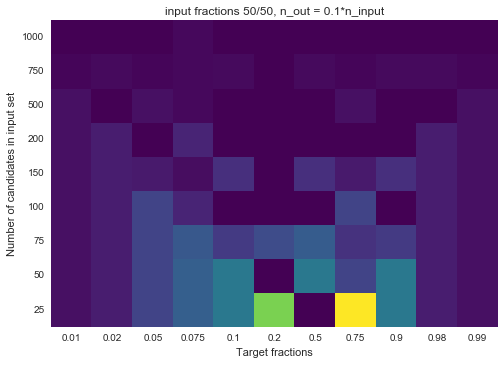

In [11]:
plt.pcolormesh(metric1.T, cmap=cmap.viridis)
plt.xticks(np.arange(len(attr1_targets))+0.5,attr1_targets)
plt.xlabel("Target fractions")
plt.yticks(np.arange(len(n_inputs))+0.5, n_inputs);
plt.ylabel("Number of candidates in input set")
plt.xlim(0,len(attr1_targets))
plt.ylim(0, len(n_inputs))
plt.title("input fractions 50/50, n_out = 0.1*n_input")

purple = good, yellow = bad

The points where `entrofy` fails are mostly at low input rates. Even for an input fraction of 0.1, this will pick only 2 people, hence getting one wrong has a big effect on the metric.

Let's instead pick a higher number of candidates in the output set:

In [13]:
input_fractions = [0.5, 0.5]

attr1_targets = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 0.9, 0.98, 0.99]

targets = [(t, 1.0-t) for t in attr1_targets]

ntargets = len(targets)

nsims=20

# size of candidate set
n_inputs = [25, 50, 75, 100, 150, 200, 500, 750, 1000]
ni = len(n_inputs)

target_proportion = 0.5

metric1 = np.zeros((ntargets, ni))
metric1_std = np.zeros((ntargets, ni))
for j, ta in enumerate(targets):
    for k, ni in enumerate(n_inputs):
        metric_mean, metric_std = run_single_category_experiment(ta, ni, target_proportion, alpha, ntrials,
                                               input_fractions=0.5, nsims=nsims)
        if np.isnan(metric_mean):
            print("Metric is NaN!")
            print("I am on target run %i"%i)
            print("I am on inputs run %i"%j)
        metric1[j,k] = metric_mean
        metric1_std[j,k] = metric_std



In [14]:
# save experiment to disk
exp2 = {"input_fractions":input_fractions,
        "targets":targets,
       "ninputs":n_inputs,
       "target proportions":target_proportion,
       "alpha":alpha,
       "ntrials":ntrials,
       "results mean":metric1,
       "results std":metric1_std}

with open("./exp2_1cat.pkl", "w") as f:
    pickle.dump(exp2, f)

In [15]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
d = metric1.T<acceptable_deviation
test_df = pd.DataFrame(metric1, index=attr1_targets, columns=n_inputs)

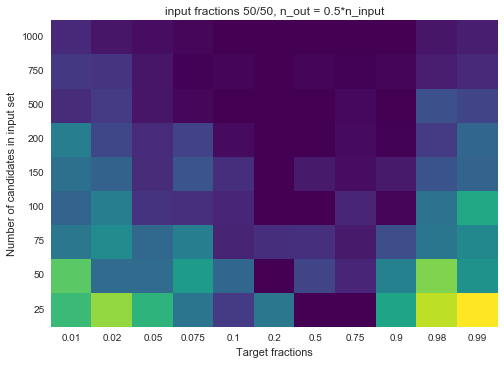

In [16]:
plt.pcolormesh(metric1.T, cmap=cmap.viridis)
plt.xticks(np.arange(len(attr1_targets))+0.5,attr1_targets)
plt.xlabel("Target fractions")
plt.yticks(np.arange(len(n_inputs))+0.5, n_inputs);
plt.ylabel("Number of candidates in input set")
plt.xlim(0,len(attr1_targets))
plt.ylim(0, len(n_inputs))
plt.title("input fractions 50/50, n_out = 0.5*n_input")

Again, it mostly fails when there are few input candidates and the target fractions differ a lot from the responses in the input set. 

Let's make a third try with the output set being a large fraction of the input set:

In [36]:
input_fractions = 0.5

attr1_targets = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 0.9, 0.98, 0.99]

targets = [(t, 1.0-t) for t in attr1_targets]
ntargets = len(targets)

nsims = 20

# size of candidate set
n_inputs = [25, 50, 75, 100, 150, 200, 500, 750, 1000]
ni = len(n_inputs)

target_proportion = 0.9

metric1 = np.zeros((ntargets, ni))
metric1_std = np.zeros((ntargets, ni))
for j, ta in enumerate(targets):
    for k, ni in enumerate(n_inputs):
        metric_mean, metric_std = run_single_category_experiment(ta, ni, target_proportion, alpha, ntrials,
                                               input_fractions=0.5, nsims=nsims)
        if np.isnan(metric_mean):
            print("Metric is NaN!")
            print("I am on target run %i"%i)
            print("I am on inputs run %i"%j)
        metric1[j,k] = metric_mean
        metric1_std[j,k] = metric_std




In [37]:
# save experiment to disk
exp3 = {"input_fractions":input_fractions,
        "targets":targets,
       "ninputs":n_inputs,
       "target proportions":target_proportion,
       "alpha":alpha,
       "ntrials":ntrials,
       "results mean":metric1,
       "results std":metric1_std}

with open("./exp3_1cat.pkl", "w") as f:
    pickle.dump(exp3, f)

In [38]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
d = metric1.T<acceptable_deviation
test_df = pd.DataFrame(metric1, index=attr1_targets, columns=n_inputs)

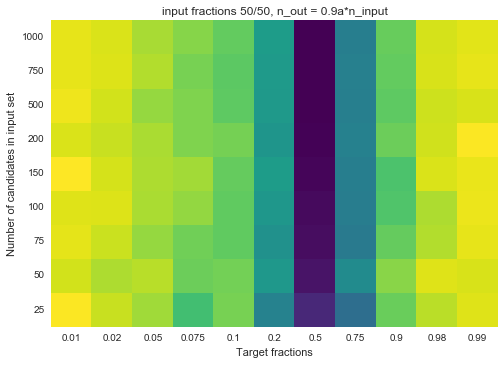

In [39]:
plt.pcolormesh(metric1.T, cmap=cmap.viridis)
plt.xticks(np.arange(len(attr1_targets))+0.5,attr1_targets)
plt.xlabel("Target fractions")
plt.yticks(np.arange(len(n_inputs))+0.5, n_inputs);
plt.ylabel("Number of candidates in input set")
plt.xlim(0,len(attr1_targets))
plt.ylim(0, len(n_inputs))
plt.title("input fractions 50/50, n_out = 0.9a*n_input")

So, trying to select a large fraction of the applicant pool, but having input and target fractions being really disparate is a bad thing, as one would expect. 

Let's also vary the input fractions for another axis:

Let's also vary the input fractions:

In [21]:
input_fractions = 0.1

attr1_targets = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 0.9, 0.98, 0.99]

targets = [(t, 1.0-t) for t in attr1_targets]

ntargets = len(targets)

nsims = 20

# size of candidate set
n_inputs = [25, 50, 75, 100, 150, 200, 500, 750, 1000]
ni = len(n_inputs)

target_proportion = 0.1

metric1 = np.zeros((ntargets, ni))
metric1_std = np.zeros((ntargets, ni))
for j, ta in enumerate(targets):
    for k, ni in enumerate(n_inputs):
        metric_mean, metric_std = run_single_category_experiment(ta, ni, target_proportion, alpha, ntrials,
                                               input_fractions=input_fractions, nsims=nsims)
        if np.isnan(metric_mean):
            print("Metric is NaN!")
            print("I am on target run %i"%i)
            print("I am on inputs run %i"%j)
        metric1[j,k] = metric_mean
        metric1_std[j,k] = metric_std




In [22]:
# save experiment to disk
exp4 = {"input_fractions":input_fractions,
        "targets":targets,
       "ninputs":n_inputs,
       "target proportions":target_proportion,
       "alpha":alpha,
       "ntrials":ntrials,
       "results mean":metric1,
       "results std":metric1_std}

with open("./exp4_1cat.pkl", "w") as f:
    pickle.dump(exp4, f)

In [23]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
d = metric1.T<acceptable_deviation
test_df = pd.DataFrame(metric1, index=attr1_targets, columns=n_inputs)

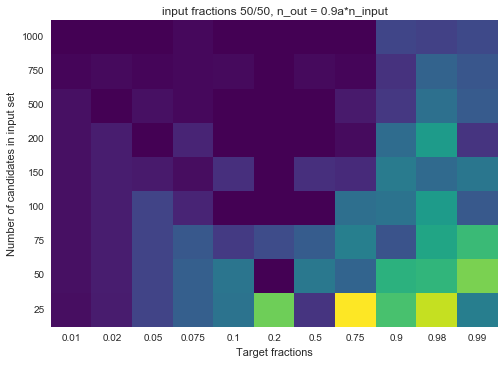

In [24]:
plt.pcolormesh(metric1.T, cmap=cmap.viridis)
plt.xticks(np.arange(len(attr1_targets))+0.5,attr1_targets)
plt.xlabel("Target fractions")
plt.yticks(np.arange(len(n_inputs))+0.5, n_inputs);
plt.ylabel("Number of candidates in input set")
plt.xlim(0,len(attr1_targets))
plt.ylim(0, len(n_inputs))
plt.title("input fractions 50/50, n_out = 0.9a*n_input")

Change target proportion:

In [25]:
input_fractions = 0.1

attr1_targets = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 0.9, 0.98, 0.99]

targets = [(t, 1.0-t) for t in attr1_targets]

ntargets = len(targets)

nsims = 20

# size of candidate set
n_inputs = [25, 50, 75, 100, 150, 200, 500, 750, 1000]
ni = len(n_inputs)

target_proportion = 0.5

metric1 = np.zeros((ntargets, ni))
metric1_std = np.zeros((ntargets, ni))
for j, ta in enumerate(targets):
    for k, ni in enumerate(n_inputs):
        metric_mean, metric_std = run_single_category_experiment(ta, ni, target_proportion, alpha, ntrials,
                                               input_fractions=input_fractions, nsims=nsims)
        if np.isnan(metric_mean):
            print("Metric is NaN!")
            print("I am on target run %i"%i)
            print("I am on inputs run %i"%j)
        metric1[j,k] = metric_mean
        metric1_std[j,k] = metric_std





In [26]:
# save experiment to disk
exp5 = {"input_fractions":input_fractions,
        "targets":targets,
       "ninputs":n_inputs,
       "target proportions":target_proportion,
       "alpha":alpha,
       "ntrials":ntrials,
       "results mean":metric1,
       "results std":metric1_std}

with open("./exp5_1cat.pkl", "w") as f:
    pickle.dump(exp5, f)

In [27]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
d = metric1.T<acceptable_deviation
test_df = pd.DataFrame(metric1, index=attr1_targets, columns=n_inputs)

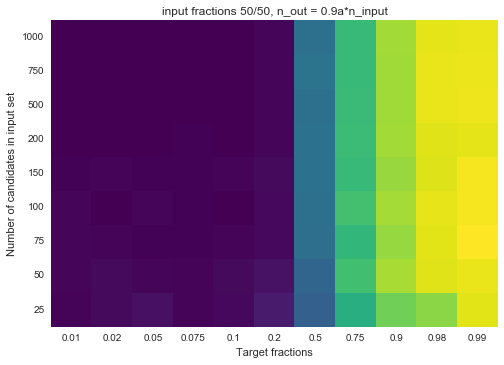

In [28]:
plt.pcolormesh(metric1.T, cmap=cmap.viridis)
plt.xticks(np.arange(len(attr1_targets))+0.5,attr1_targets)
plt.xlabel("Target fractions")
plt.yticks(np.arange(len(n_inputs))+0.5, n_inputs);
plt.ylabel("Number of candidates in input set")
plt.xlim(0,len(attr1_targets))
plt.ylim(0, len(n_inputs))
plt.title("input fractions 50/50, n_out = 0.9a*n_input")

In [29]:
input_fractions = 0.1

attr1_targets = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 0.9, 0.98, 0.99]

targets = [(t, 1.0-t) for t in attr1_targets]

ntargets = len(targets)

nsims = 20

# size of candidate set
n_inputs = [25, 50, 75, 100, 150, 200, 500, 750, 1000]
ni = len(n_inputs)

target_proportion = 0.9

metric1 = np.zeros((ntargets, ni))
metric1_std = np.zeros((ntargets, ni))
for j, ta in enumerate(targets):
    for k, ni in enumerate(n_inputs):
        metric_mean, metric_std = run_single_category_experiment(ta, ni, target_proportion, alpha, ntrials,
                                               input_fractions=input_fractions, nsims=nsims)
        if np.isnan(metric_mean):
            print("Metric is NaN!")
            print("I am on target run %i"%i)
            print("I am on inputs run %i"%j)
        metric1[j,k] = metric_mean
        metric1_std[j,k] = metric_std





In [30]:
# save experiment to disk
exp6 = {"input_fractions":input_fractions,
        "targets":targets,
       "ninputs":n_inputs,
       "target proportions":target_proportion,
       "alpha":alpha,
       "ntrials":ntrials,
       "results mean":metric1,
       "results std":metric1_std}

with open("./exp6_1cat.pkl", "w") as f:
    pickle.dump(exp6, f)

In [31]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
d = metric1.T<acceptable_deviation
test_df = pd.DataFrame(metric1, index=attr1_targets, columns=n_inputs)

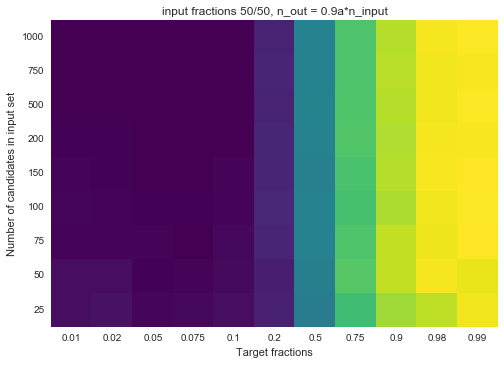

In [32]:
plt.pcolormesh(metric1.T, cmap=cmap.viridis)
plt.xticks(np.arange(len(attr1_targets))+0.5,attr1_targets)
plt.xlabel("Target fractions")
plt.yticks(np.arange(len(n_inputs))+0.5, n_inputs);
plt.ylabel("Number of candidates in input set")
plt.xlim(0,len(attr1_targets))
plt.ylim(0, len(n_inputs))
plt.title("input fractions 50/50, n_out = 0.9a*n_input")

### Combining Plots

Let's first have a look at the plots varying output fraction while keeping input fraction constant at 0.5:

In [40]:
with open("exp1_1cat.pkl", 'r') as f:
    exp1 = pickle.load(f)
    
with open("exp2_1cat.pkl", 'r') as f:
    exp2 = pickle.load(f)

with open("exp3_1cat.pkl", 'r') as f:
    exp3 = pickle.load(f)



In [46]:
m1 = exp1["results mean"]
m2 = exp2["results mean"]
m3 = exp3["results mean"]


In [47]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
m1_map = m1.T<acceptable_deviation
m2_map = m2.T<acceptable_deviation

m3_map = m3.T<acceptable_deviation



In [50]:
m1_map

array([[ True,  True, False, False, False, False,  True, False, False,
         True,  True],
       [ True,  True, False, False, False,  True, False, False, False,
         True,  True],
       [ True,  True, False, False,  True, False, False,  True,  True,
         True,  True],
       [ True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]], dtype=bool)

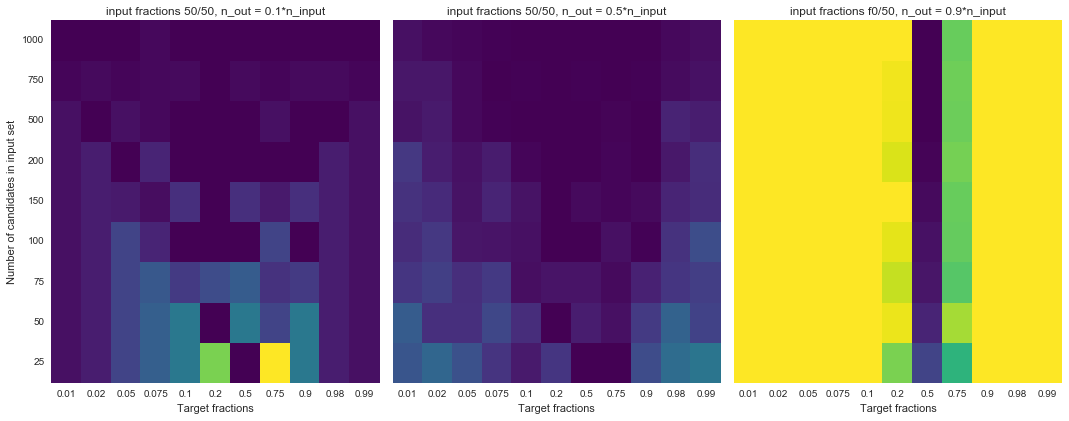

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True)


ax1.pcolormesh(m1.T, cmap=cmap.viridis, vmin=0, vmax=0.5)
ax1.set_xticks(np.arange(len(attr1_targets))+0.5)
ax1.set_xticklabels(attr1_targets)

ax1.set_xlabel("Target fractions")
ax1.set_yticks(np.arange(len(n_inputs))+0.5)
ax1.set_yticklabels(n_inputs)

ax1.set_ylabel("Number of candidates in input set")
ax1.set_xlim(0,len(attr1_targets))
ax1.set_ylim(0, len(n_inputs))
ax1.set_title("input fractions 50/50, n_out = 0.1*n_input")


ax2.pcolormesh(m2.T, cmap=cmap.viridis, vmin=0, vmax=0.5)
ax2.set_xticks(np.arange(len(attr1_targets))+0.5)
ax2.set_xticklabels(attr1_targets)
ax2.set_xlabel("Target fractions")
ax2.set_yticks(np.arange(len(n_inputs))+0.5)
ax2.set_xlim(0,len(attr1_targets))
ax2.set_ylim(0, len(n_inputs))
ax2.set_title("input fractions 50/50, n_out = 0.5*n_input")


ax3.pcolormesh(m3.T, cmap=cmap.viridis, vmin=0, vmax=0.5)
ax3.set_xticks(np.arange(len(attr1_targets))+0.5)
ax3.set_xticklabels(attr1_targets)
ax3.set_xlabel("Target fractions")
ax3.set_yticks(np.arange(len(n_inputs))+0.5)
ax3.set_xlim(0,len(attr1_targets))
ax3.set_ylim(0, len(n_inputs))
ax3.set_title("input fractions f0/50, n_out = 0.9*n_input")

plt.tight_layout()
#plt.colorbar()



In [52]:
with open("exp4_1cat.pkl", 'r') as f:
    exp4 = pickle.load(f)
    
with open("exp5_1cat.pkl", 'r') as f:
    exp5 = pickle.load(f)

with open("exp6_1cat.pkl", 'r') as f:
    exp6 = pickle.load(f)




In [53]:
m4 = exp4["results mean"]
m5 = exp5["results mean"]
m6 = exp6["results mean"]



In [54]:
acceptable_deviation = np.array([(t[0]/10)+(t[1]/10) for t in targets])
m4_map = m4.T<acceptable_deviation
m5_map = m5.T<acceptable_deviation
m6_map = m6.T<acceptable_deviation




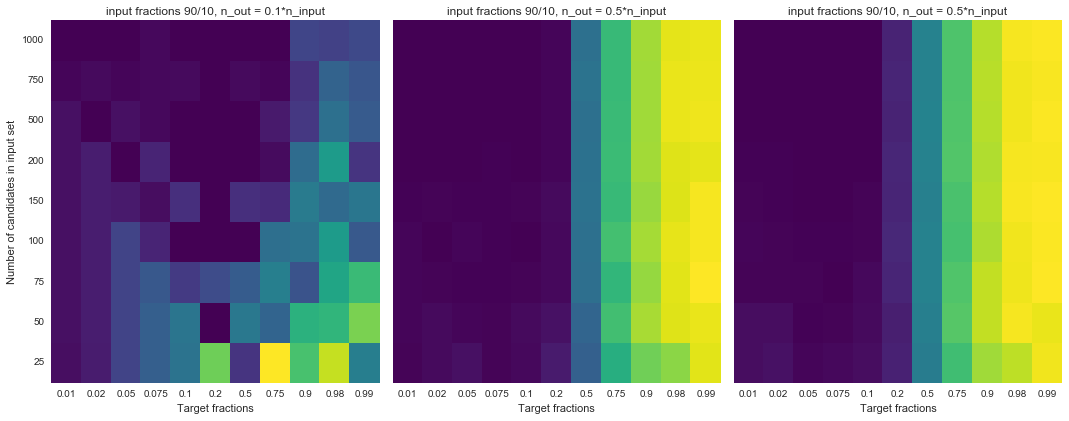

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True)


ax1.pcolormesh(m4.T, cmap=cmap.viridis)
ax1.set_xticks(np.arange(len(attr1_targets))+0.5)
ax1.set_xticklabels(attr1_targets)

ax1.set_xlabel("Target fractions")
ax1.set_yticks(np.arange(len(n_inputs))+0.5)
ax1.set_yticklabels(n_inputs)

ax1.set_ylabel("Number of candidates in input set")
ax1.set_xlim(0,len(attr1_targets))
ax1.set_ylim(0, len(n_inputs))
ax1.set_title("input fractions 90/10, n_out = 0.1*n_input")


ax2.pcolormesh(m5.T, cmap=cmap.viridis)
ax2.set_xticks(np.arange(len(attr1_targets))+0.5)
ax2.set_xticklabels(attr1_targets)
ax2.set_xlabel("Target fractions")
ax2.set_yticks(np.arange(len(n_inputs))+0.5)
ax2.set_xlim(0,len(attr1_targets))
ax2.set_ylim(0, len(n_inputs))
ax2.set_title("input fractions 90/10, n_out = 0.5*n_input")


ax3.pcolormesh(m6.T, cmap=cmap.viridis)
ax3.set_xticks(np.arange(len(attr1_targets))+0.5)
ax3.set_xticklabels(attr1_targets)
ax3.set_xlabel("Target fractions")
ax3.set_yticks(np.arange(len(n_inputs))+0.5)
ax3.set_xlim(0,len(attr1_targets))
ax3.set_ylim(0, len(n_inputs))
ax3.set_title("input fractions 90/10, n_out = 0.5*n_input")

plt.tight_layout()
#plt.colorbar()




## Algorithm Tests

We're going to test how well the algorithm works for a 2-attribute case. 

We will vary:
* $\alpha$ between 0.1 and 1: [1/10, 1/4, 1/3, 1/2, 1]
* $n_\mathrm{out}$, the number of participants in the output set, between 10 and 100: [10, 20, 50, 80, 100]
* $n_\mathrm{random}$, the number of random additions to the output set, between 1 and 1000: [1, 5, 10, 20, 50, 100, 200, 500, 1000]
* $p_1$ and $p_2$, the target fractions of the solution, between 0.1 and 0.5: [0.1, 0.2, 0.3, 0.4, 0.5]
* $y_1$ and $y_2$, the fractions of the random noise set, between 0 and 0.5: [0, 0.1, 0.2, 0.3, 0.4, 0.5]

We will set `n_trials=1`, and run $N=100$ simulations of each case.


In [38]:
import six

In [261]:
def binarize(df, mappers):

    df_binary = pd.DataFrame(index=df.index)

    all_probabilities = {}
    for key, mapper in six.iteritems(mappers):
        new_df = mapper.transform(df[key])
        df_binary = df_binary.join(new_df)
        all_probabilities.update(mapper.targets)

    # Construct the target probability vector and weight vector
    target_prob = np.empty(len(df_binary.columns))
    for i, key in enumerate(df_binary.columns):
        target_prob[i] = all_probabilities[key]

    q = np.round(target_prob*len(df))
    w = np.ones_like(q)

    return df_binary.values, q, w

In [286]:
def objective(X, w, q, alpha):
    """
    X : data
    w : list of weights
    q : list of target probabilities
    n : number of participants to select
    """
    return ((np.minimum(q, X))**(alpha)).dot(w)



In [287]:
def compute_objective(solution, mappers, probs, alpha=0.5):
    X, q, w = binarize(solution, mappers)
    return objective(np.nansum(X, axis=0), w, q, alpha)


In [288]:
def create_solution(probs, n_out):
    """
    Create a solution with an arbitrary number of categories,
    but each of which is constrained to two attributes ("Yes", "No").

    Parameters
    ----------
    probs : iterable
        List of probabilities for each category.

    n_out : integer
        The size of the output sample

    Returns
    -------
    df : pandas.DataFrame
        A DataFrame with the generated data set.

    """
    df = pd.DataFrame()
    mappers = {}
    for i, p in enumerate(probs):

        name = "Attribute %i"%(i+1)
        prefix = "attr%i"%(i+1)

        p_pos = int(p*n_out)
        attr = ["Yes" for _ in range(p_pos)]
        attr.extend(["No" for _ in range(n_out-p_pos)])
        attr = np.array(attr)
        np.random.shuffle(attr)

        # add column to DataFrame
        df[name] = attr

        # let's create mappers while we're at it:
        attr_dict = {"Yes":p, "No":1.0-p}
        mp = ObjectMapper(df[name], targets=attr_dict, prefix=prefix)

        mappers[name] = mp

    return df, mappers


In [289]:
def create_sample(yrandom, n_random):
    """
    Create a random sample of participants with an arbitrary number
    of attributes, which roughly follow the probabilities given in
    `yrandom`.

    Parameters
    ----------
    yrandom : iterable
        List of probabilities for each category.

    n_random : integer
        The size of the output sample

    Returns
    -------
    df : pandas.DataFrame
        A DataFrame with the generated data set.

    """


    attributes = []
    for y in yrandom:
        y_prob = [y, 1.0-y]
        # pick randomly from target fractions with the correct
        attr = np.random.choice(["Yes", "No"], replace=True, p=y_prob, size=n_random)

        attributes.append(attr)

    attribute_names = ["Attribute %i"%i for i in range(1,len(yrandom)+1, 1)]
    df = pd.DataFrame(np.array(attributes).T, columns=attribute_names)

    return df


In [290]:
def create_sim(p1, p2, y1, y2, n_out, n_random, alpha):
    """
    Create a simulation with 2 categories, each of which has
    2 attributes.

    Parameters
    ----------
    p1, p2: (0, 0.5]
        The fraction of participants in each category having attribute "Yes"
        for generating the output set

    y1, y2: [0, 0.5]
        The fraction of applicants in each category having the attribute "Yes"
        for the randomized set for confusing the solution

    n_out : int
        The number of participants in the output set

    n_random : int
        The number of entries added to the solution in the input set to confuse
        the algorithm

    """
    # pick a solution
    solution, mappers = create_solution([p1, p2], n_out)

    max_score = compute_objective(solution, mappers, [p1, p2], alpha)

    # pick random sample for confusion
    random_sample = create_sample([y1, y2], n_random)

    # combine the two
    sample = pd.concat([solution, random_sample])

    # shuffle the data set
    sample = sample.sample(frac=1).reset_index(drop=True)

    return sample, mappers, max_score


In [291]:
p1 = 0.1
p2 = 0.2

y1 = 0.1
y2 = 0.5

n_out = 80
n_random = 20

sim, sim_mappers, sim_max_score = create_sim(p1, p2, y1, y2, n_out, n_random, 0.5)

In [292]:
sim_max_score

23.313708498984759

Next, we can run entrofy on that simulation:

In [293]:
alpha = 0.5
idx, max_score = entrofy.core.entrofy(sim, n_out, mappers=sim_mappers, alpha=0.5)

In [294]:
max_score

23.313708498984759

### Loading Results

We ran those experients described above in a script called `experiments.py`. Let's load the results from those runs:

In [6]:
import glob

In [9]:
res_files = glob.glob("../data/*.pkl")
print(res_files)

['../data/algorithm_exp_alpha=0.33.pkl', '../data/algorithm_exp_alpha=0.50.pkl', '../data/algorithm_exp_alpha=1.00.pkl']


In [197]:
res = {}
for rf in res_files:
    # get alpha value
    a = rf.split("=")[1][:4]
    with open(rf, "r") as f:
        res[a] = pickle.load(f)
    

As a reminder. Each element in the dictionary corresponds to a value of $\alpha$. 

For each value of $\alpha$, we vary:
* $n_\mathrm{out}$, the number of participants in the output set, between 10 and 100: [10, 20, 50, 80, 100]
* $n_\mathrm{random}$, the number of random additions to the output set, between 1 and 1000: [1, 5, 10, 20, 50, 100, 200, 500, 1000]
* $p_1$ and $p_2$, the target fractions of the solution, between 0.1 and 0.5: [0.1, 0.2, 0.3, 0.4, 0.5]
* $y_1$ and $y_2$, the fractions of the random noise set, between 0 and 0.5: [0, 0.1, 0.2, 0.3, 0.4, 0.5]

For each value, we run 100 simulations. 

In [241]:
n_out = np.array([10, 20, 50, 80, 100, 200])
n_random = np.array([1, 5, 10, 20, 50, 100, 200, 500, 1000])
p1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
p2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
y1 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])
y2 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])

### Dependence of success on  $n_\mathrm{out}$ versus  $n_\mathrm{random}$

Let's check how success depends on $n_\mathrm{out}$ and $n_\mathrm{random}$, for both a case where input/output fractions are similar and a case where they are different.

In [242]:
r = res["0.50"]

In [243]:
test_metric1 = r[:,:,-1, -1, -1, -1, :]
test_metric1.shape

test_metric2 = r[:,:,-1, -1, 1, 1, :]
test_metric2.shape

(6, 9, 100)

In [244]:
test_metric1_mask = test_metric1>0
test_metric2_mask = test_metric2>0

In [245]:
test_sum1 = np.sum(test_metric1_mask, axis=2)
test_sum1.shape

test_sum2 = np.sum(test_metric2_mask, axis=2)
test_sum2.shape

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

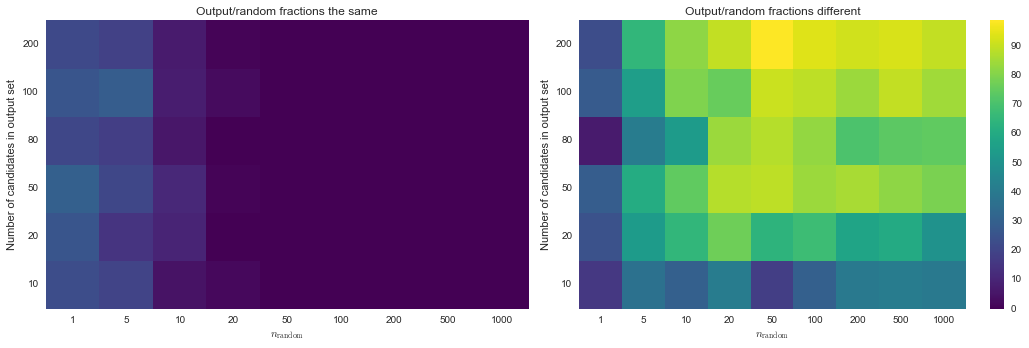

In [246]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

im = ax1.pcolormesh(test_sum1, cmap=cmap.viridis,
                   vmin=vmin, vmax=vmax)
ax1.set_xticks(np.arange(len(n_random))+0.5)
ax1.set_xticklabels(n_random)

ax1.set_xlabel(r"$n_\mathrm{random}$")
ax1.set_yticks(np.arange(len(n_out))+0.5)
ax1.set_yticklabels(n_out)

ax1.set_ylabel("Number of candidates in output set")
ax1.set_xlim(0,len(n_random))
ax1.set_ylim(0, len(n_out))
ax1.set_title("Output/random fractions the same")
#fig.colorbar(im)


im = ax2.pcolormesh(test_sum2, cmap=cmap.viridis,
                   vmin=vmin, vmax=vmax)
ax2.set_xticks(np.arange(len(n_random))+0.5)
ax2.set_xticklabels(n_random)

ax2.set_xlabel(r"$n_\mathrm{random}$")
ax2.set_yticks(np.arange(len(n_out))+0.5)
ax2.set_yticklabels(n_out)

ax2.set_ylabel("Number of candidates in output set")
ax2.set_xlim(0,len(n_random))
ax2.set_ylim(0, len(n_out))
ax2.set_title("Output/random fractions different")
fig.colorbar(im)

plt.tight_layout()

The colours are percentages out of a hundred for failure.

### Changing one Feature To an imbalance


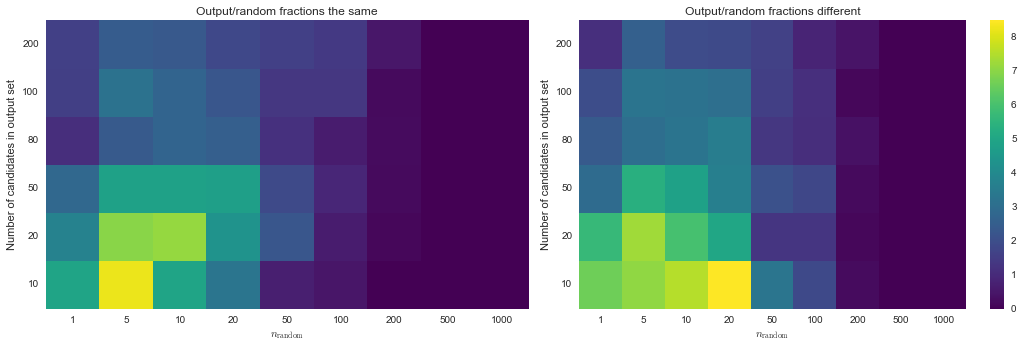

In [249]:
test_metric1 = r[:,:,-1, -1, 1, -1, :]
test_metric1.shape

test_metric2 = r[:,:,-1, -1, -1, 1, :]
test_metric2.shape

test_metric1_mask = test_metric1>0
test_metric2_mask = test_metric2>0

test_sum1 = np.sum(test_metric1, axis=2)
test_sum1.shape

test_sum2 = np.sum(test_metric2, axis=2)
test_sum2.shape

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

im = ax1.pcolormesh(test_sum1, cmap=cmap.viridis,
                   vmin=vmin, vmax=vmax)
ax1.set_xticks(np.arange(len(n_random))+0.5)
ax1.set_xticklabels(n_random)

ax1.set_xlabel(r"$n_\mathrm{random}$")
ax1.set_yticks(np.arange(len(n_out))+0.5)
ax1.set_yticklabels(n_out)

ax1.set_ylabel("Number of candidates in output set")
ax1.set_xlim(0,len(n_random))
ax1.set_ylim(0, len(n_out))
ax1.set_title("Output/random fractions the same")
#fig.colorbar(im)


im = ax2.pcolormesh(test_sum2, cmap=cmap.viridis,
                   vmin=vmin, vmax=vmax)
ax2.set_xticks(np.arange(len(n_random))+0.5)
ax2.set_xticklabels(n_random)

ax2.set_xlabel(r"$n_\mathrm{random}$")
ax2.set_yticks(np.arange(len(n_out))+0.5)
ax2.set_yticklabels(n_out)

ax2.set_ylabel("Number of candidates in output set")
ax2.set_xlim(0,len(n_random))
ax2.set_ylim(0, len(n_out))
ax2.set_title("Output/random fractions different")
fig.colorbar(im)

plt.tight_layout()

Let's change the ratio of one random data set from "the same" to "different" in steps and see how it changes the results:

In [223]:
test_metric1 = r[:,:,-1, -1, :, -1,:]
test_metric2 = r[:,:,0, -1, :, -1, :]

test_metric1_mask = test_metric1>0
test_metric2_mask = test_metric2>0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

In [238]:
test_sum1[:,:,1]

array([[21, 35, 21, 14,  3,  2,  0,  0,  0],
       [23, 43, 44, 27, 14,  4,  1,  0,  0],
       [28, 48, 48, 47, 19,  9,  2,  0,  0],
       [14, 30, 34, 32, 15,  8,  3,  0,  0],
       [22, 45, 38, 32, 19, 19,  3,  0,  0],
       [32, 49, 47, 37, 32, 28, 10,  0,  0]])

In [230]:
np.where(test_sum1[:,:,1] == np.max(test_sum1[:,:,1]))

(array([5]), array([1]))

In [231]:
test_sum1[5,1,1]

49

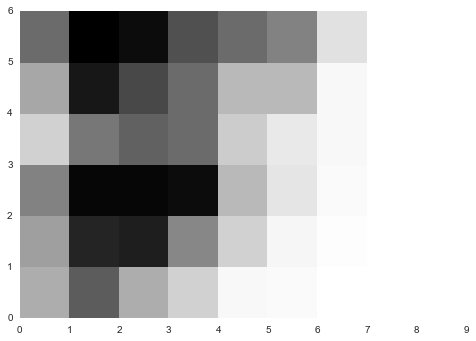

In [226]:
plt.pcolormesh(test_sum1[:,:,1])

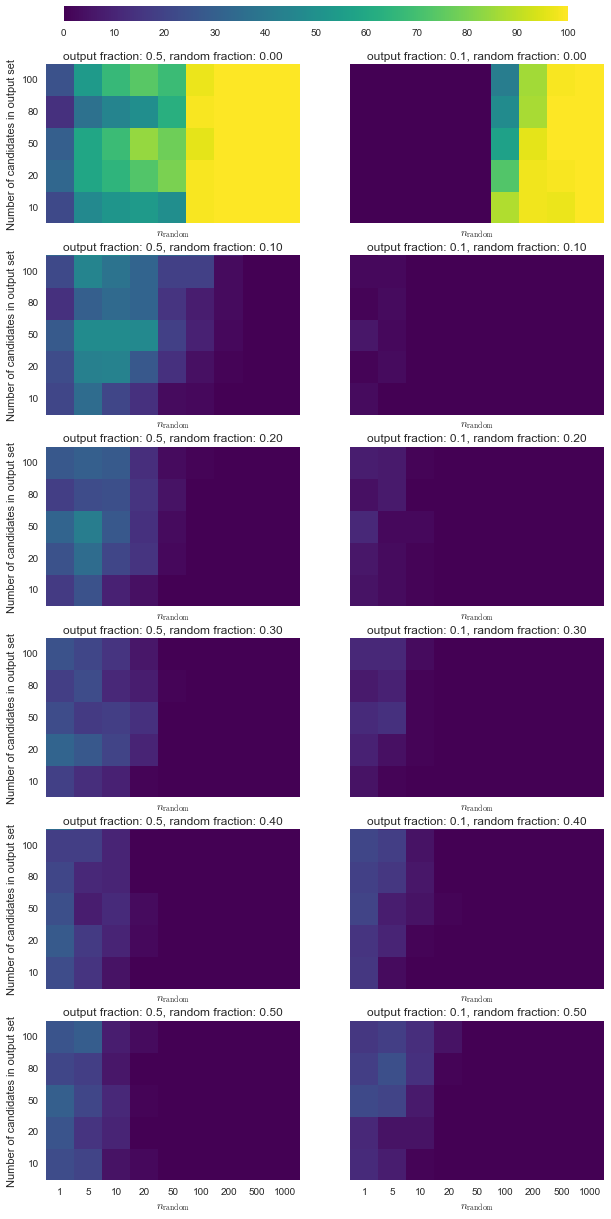

In [224]:
fig, axes = plt.subplots(len(y1),2,figsize=(10,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_sum1[:,:,i]
    tm2 = test_sum2[:,:,i]
    
    ax1 = axes[i,0]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])
        
    ax2 = axes[i,1] 
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax2.set_xticks(np.arange(len(n_random))+0.5)
    ax2.set_xticklabels(n_random)

    ax2.set_xlabel(r"$n_\mathrm{random}$")
    ax2.set_yticks(np.arange(len(n_out))+0.5)
    ax2.set_yticklabels(n_out)

    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title("output fraction: 0.1, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')



Let's look at the other attribute. What happens if I mess with the fraction of the random additions of one attribute, but look at the other? 

In [195]:
test_metric1 = r[:, :, -1, -1, -1, :, :]
test_metric2 = r[:, :, 0, -1, -1, :, :]

test_metric1_mask = test_metric1>0
test_metric2_mask = test_metric2>0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

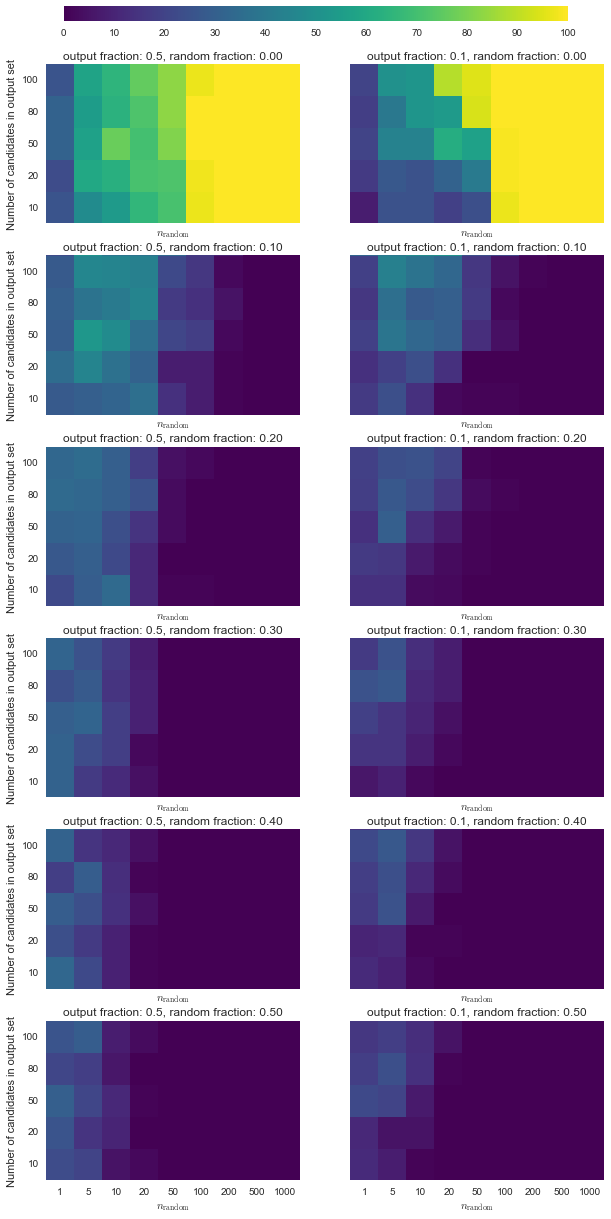

In [196]:
fig, axes = plt.subplots(len(y1),2,figsize=(10,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_sum1[:,:,i]
    tm2 = test_sum2[:,:,i]
    
    ax1 = axes[i,0]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])
        
    ax2 = axes[i,1] 
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax2.set_xticks(np.arange(len(n_random))+0.5)
    ax2.set_xticklabels(n_random)

    ax2.set_xlabel(r"$n_\mathrm{random}$")
    ax2.set_yticks(np.arange(len(n_out))+0.5)
    ax2.set_yticklabels(n_out)

    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title("output fraction: 0.1, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')




To remind myself: in the left column, I'm showing results for the target fraction *always* being 0.5, in the right colum the target fraction *always* 0.1. What I am varying is the proportion of that attribute in the *random sample* added to the solution. In the first set of plots, I'd varied the attribute of the random sample of the **same** attribute that I was also varying the target fractions for. In this plot, I'm showing plots where the target fraction is always the same (0.5 on the left or 0.1 on the right), and where the random sample added *for that same attribute* is always 0.5. But I am plotting the different fractions of random sample added for the *other* attribute, whose solution is set to 0.5 in all plots. Phew. That was confusing!

What do I see here? Well, if I have a random fraction of 0 for either attribute (i.e. people of that attribute occur *only* in the solution), it doesn't look great in any case. This is especially true when the single valid solution is embedded in a large random sample that differs drastically from the target fractions. 

## $\alpha$ = 1.0

Let's try the same for $\alpha = 1.0$.

In [362]:
n_out = np.array([10, 20, 50, 80, 100, 200])
n_random = np.array([1, 5, 10, 20, 50, 100, 200, 500, 1000])
p1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
p2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
y1 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])
y2 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])

In [363]:
with open("../data/algorithm_exp_alpha=1.00.pkl", "r") as f:
    r = pickle.load(f)

In [364]:
r.shape

(6, 9, 5, 5, 6, 6, 100)

In [365]:
test_metric1 = r[:,:,-1, -1, :, -1,:]
test_metric2 = r[:,:,0, -1, :, -1, :]


test_metric1.shape

(6, 9, 6, 100)

In [366]:
test_metric1_mask = test_metric1!=0
test_metric2_mask = test_metric2!=0

test_metric1_mask.shape

(6, 9, 6, 100)

In [367]:
test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

test_sum1.shape

(6, 9, 6)

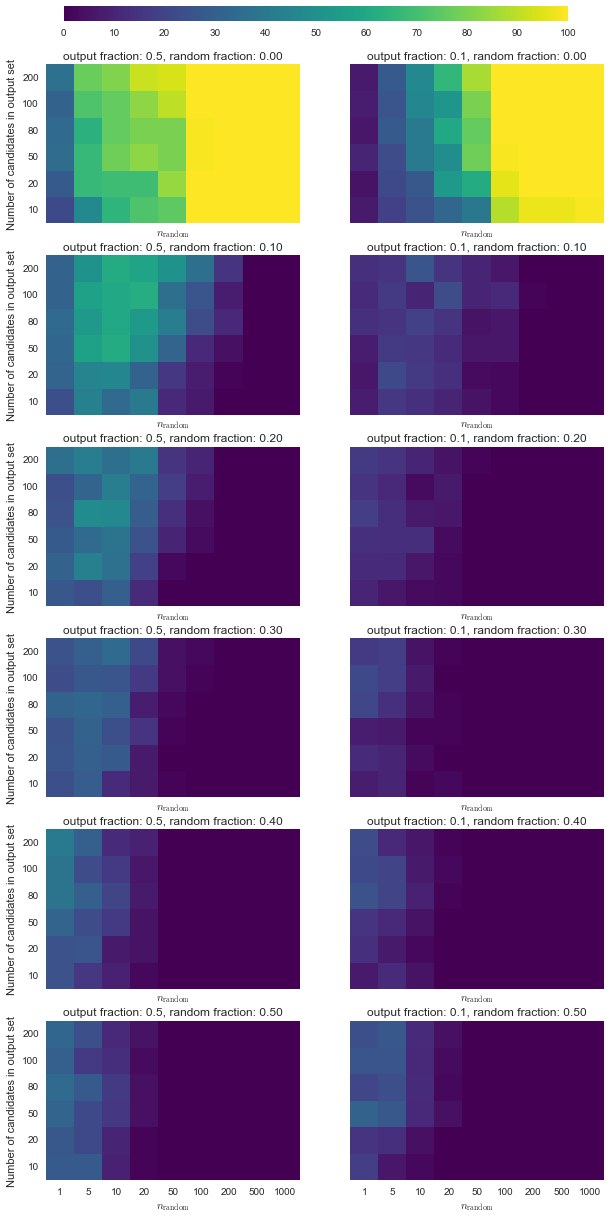

In [368]:



vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

fig, axes = plt.subplots(len(y1),2,figsize=(10,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_sum1[:,:,i]
    tm2 = test_sum2[:,:,i]
    
    ax1 = axes[i,0]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])
        
    ax2 = axes[i,1] 
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax2.set_xticks(np.arange(len(n_random))+0.5)
    ax2.set_xticklabels(n_random)

    ax2.set_xlabel(r"$n_\mathrm{random}$")
    ax2.set_yticks(np.arange(len(n_out))+0.5)
    ax2.set_yticklabels(n_out)

    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title("output fraction: 0.1, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')




And the same for varying the random fraction on attribute 2 (with everything else the same on Attribute 1):

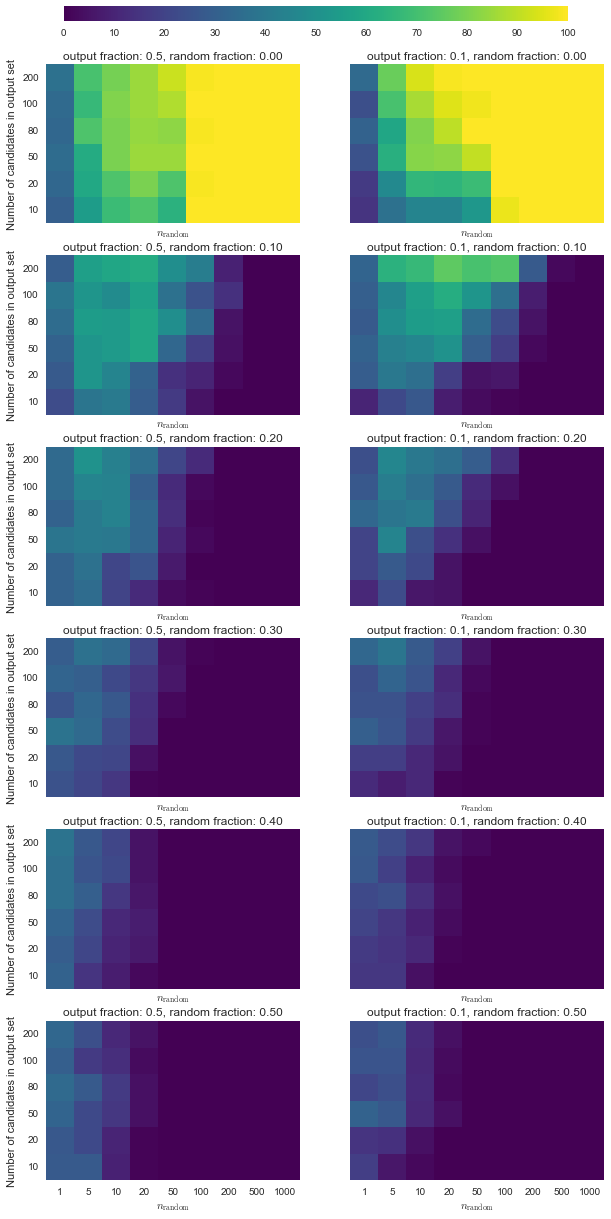

In [369]:
test_metric1 = r[:, :, -1, -1, -1, :, :]
test_metric2 = r[:, :, 0, -1, -1, :, :]

test_metric1_mask = test_metric1>0
test_metric2_mask = test_metric2>0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

fig, axes = plt.subplots(len(y1),2,figsize=(10,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_sum1[:,:,i]
    tm2 = test_sum2[:,:,i]
    
    ax1 = axes[i,0]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])
        
    ax2 = axes[i,1] 
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax2.set_xticks(np.arange(len(n_random))+0.5)
    ax2.set_xticklabels(n_random)

    ax2.set_xlabel(r"$n_\mathrm{random}$")
    ax2.set_yticks(np.arange(len(n_out))+0.5)
    ax2.set_yticklabels(n_out)

    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title("output fraction: 0.1, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')



## $\alpha$ = 0.1

Let's try the same for $\alpha = 0.1$.

In [359]:
with open("../data/algorithm_exp_alpha=0.10.pkl", "r") as f:
    r = pickle.load(f)

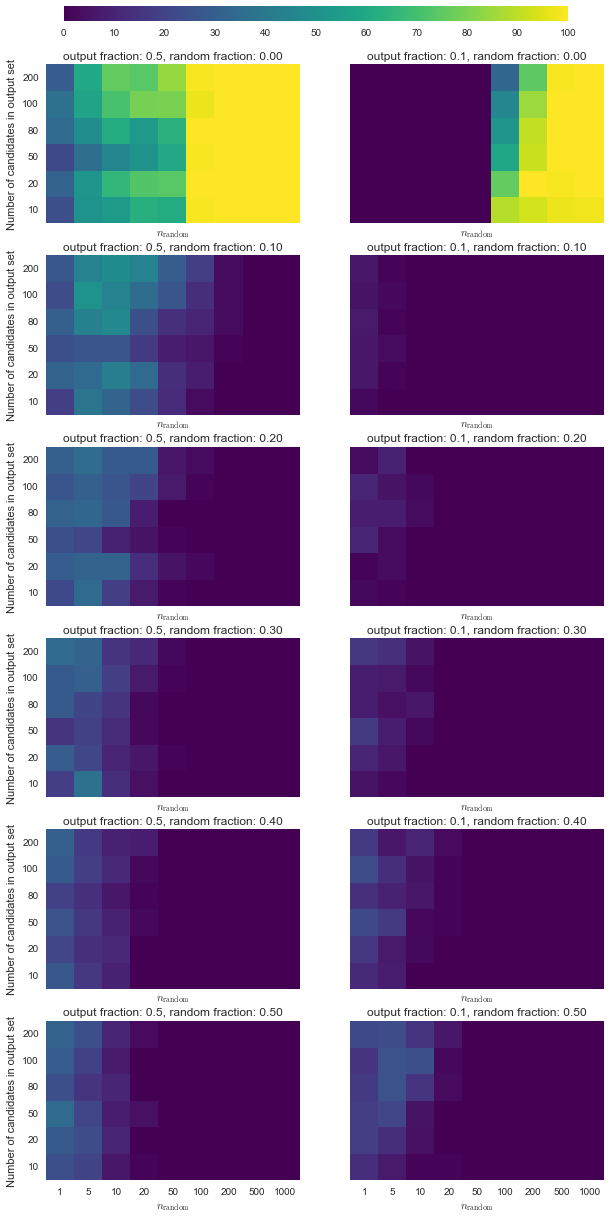

In [360]:
test_metric1 = r[:,:,-1, -1, :, -1,:]
test_metric2 = r[:,:,0, -1, :, -1, :]

test_metric1_mask = test_metric1!=0
test_metric2_mask = test_metric2!=0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

fig, axes = plt.subplots(len(y1),2,figsize=(10,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_sum1[:,:,i]
    tm2 = test_sum2[:,:,i]
    
    ax1 = axes[i,0]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])
        
    ax2 = axes[i,1] 
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax2.set_xticks(np.arange(len(n_random))+0.5)
    ax2.set_xticklabels(n_random)

    ax2.set_xlabel(r"$n_\mathrm{random}$")
    ax2.set_yticks(np.arange(len(n_out))+0.5)
    ax2.set_yticklabels(n_out)

    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title("output fraction: 0.1, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')



And the other one:

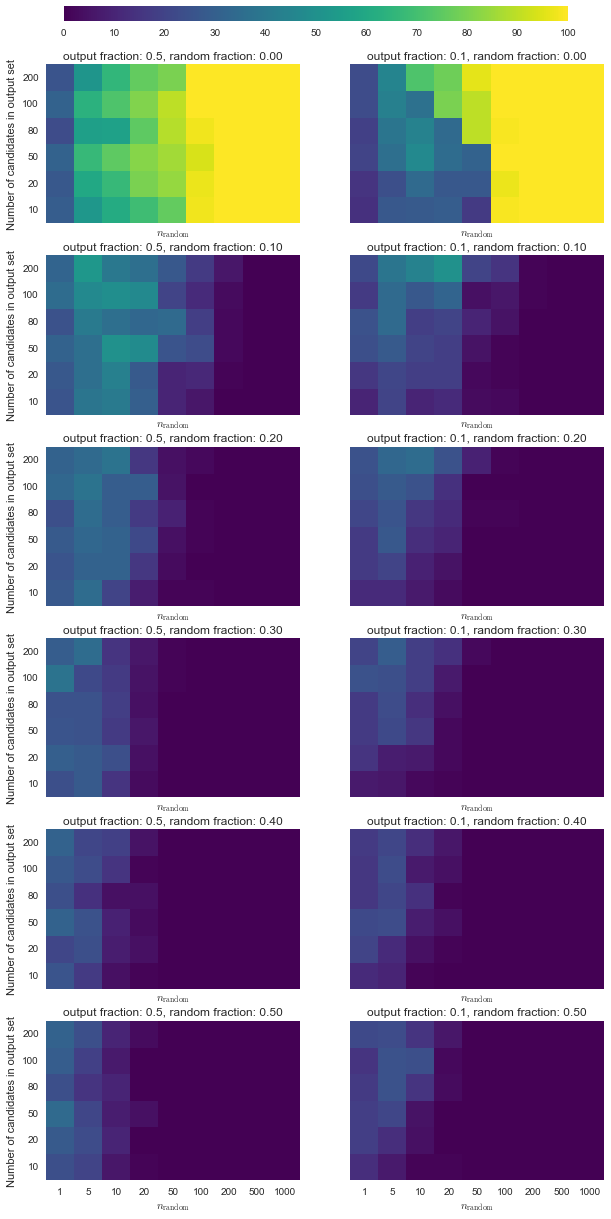

In [361]:
test_metric1 = r[:, :, -1, -1, -1, :, :]
test_metric2 = r[:, :, 0, -1, -1, :, :]

test_metric1_mask = test_metric1>0
test_metric2_mask = test_metric2>0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])

fig, axes = plt.subplots(len(y1),2,figsize=(10,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_sum1[:,:,i]
    tm2 = test_sum2[:,:,i]
    
    ax1 = axes[i,0]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])
        
    ax2 = axes[i,1] 
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax2.set_xticks(np.arange(len(n_random))+0.5)
    ax2.set_xticklabels(n_random)

    ax2.set_xlabel(r"$n_\mathrm{random}$")
    ax2.set_yticks(np.arange(len(n_out))+0.5)
    ax2.set_yticklabels(n_out)

    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title("output fraction: 0.1, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')



### Make a plot for publication

This is the plot I want to put into the paper.

In [402]:
with open("../data/algorithm_exp_alpha=0.50.pkl", "r") as f:
    r = pickle.load(f)

In [404]:
y1

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

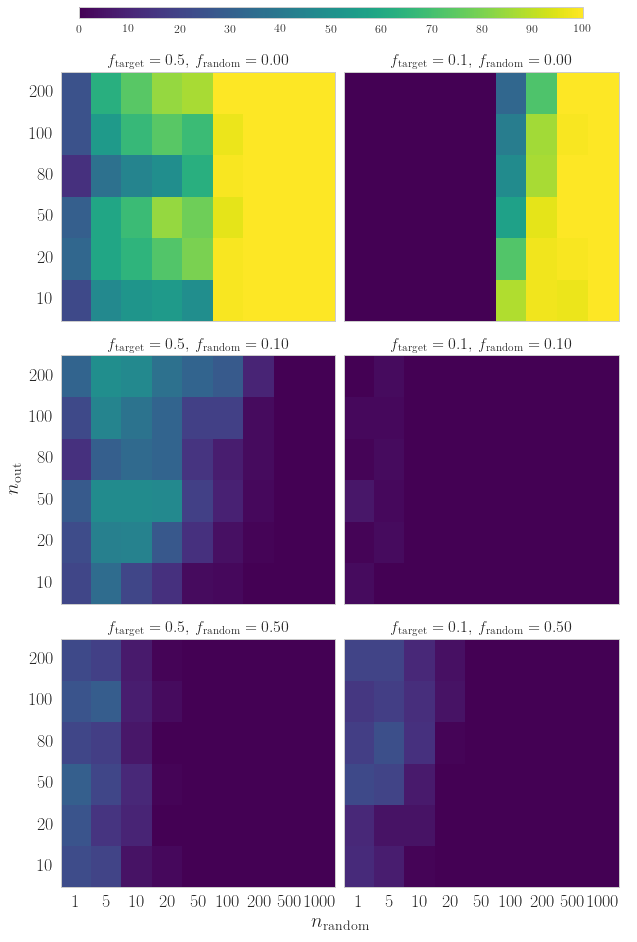

In [446]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 


test_metric1 = r[:,:,-1, -1, :, -1,:]
test_metric2 = r[:,:,0, -1, :, -1, :]

test_metric1_mask = test_metric1!=0
test_metric2_mask = test_metric2!=0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

vmin = np.min([np.min(test_sum1), np.min(test_sum2)])
vmax = np.max([np.max(test_sum1), np.max(test_sum2)])


# make the figure
fig = plt.figure(figsize=(10,15))

# change seaborn style to plain white
sns.set_style("white")

# add a single subplot 
ax = fig.add_subplot(111)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.2, rc={"axes.labelsize": 20})
sns.set_style("whitegrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)


#fig, axes = plt.subplots(3,2,figsize=(10,15), sharey=True, sharex=True)

plot_values = [0.0, 0.1, 0.5]

for i in range(0, len(plot_values), 1):
    
    plot_ind = np.where(y1 == plot_values[i])[0][0]
    
    tm1 = test_sum1[:,:,plot_ind]
    tm2 = test_sum2[:,:,plot_ind]

    ax1 = fig.add_subplot(3,2,2*i+1)
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    

    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out, fontdict={"size":18})


    if i == len(plot_values)-1:   
        ax1.set_xticks(np.arange(len(n_random))+0.5)
        ax1.set_xticklabels(n_random, fontdict={"size":18})

    else:
        ax1.get_xaxis().set_ticks([])


        
    #ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title(r"$f_\mathrm{target} = 0.5$, $f_\mathrm{random} = %.2f$"%y1[plot_ind])

    ax2 = fig.add_subplot(3,2,2*i+2)
    im = ax2.pcolormesh(tm2, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)

    #ax2.set_xlabel(r"$n_\mathrm{random}$")
    #ax2.set_yticks(np.arange(len(n_out))+0.5)
    #ax2.set_yticklabels(n_out)
    ax2.get_yaxis().set_ticks([])
 
    if i == len(plot_values)-1:   
        ax2.set_xticks(np.arange(len(n_random))+0.5)
        ax2.set_xticklabels(n_random, fontdict={"size":18})
    else:
        ax2.get_xaxis().set_ticks([])



    #ax2.set_ylabel("Number of candidates in output set")
    ax2.set_xlim(0,len(n_random))
    ax2.set_ylim(0, len(n_out))
    ax2.set_title(r"$f_\mathrm{target} = 0.1$, $f_\mathrm{random} = %.2f$"%y1[plot_ind])

ax.set_xlabel(r"$n_\mathrm{random}$")
ax.set_ylabel(r"$n_\mathrm{out}$")



cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', use_gridspec=True)
#fig.colorbar(im, orientation='horizontal', use_gridspec=True)

fig.subplots_adjust(top=0.88, wspace=0.03, hspace=0.14)
plt.savefig("../data/f1.pdf", format="pdf")



It looks like for $\alpha = 0.1$ and $\alpha = 0.5$, the results look pretty similar. Only for $\alpha = 1.0$, we have worse performance, as expected.


### How much worse is the performance for $\alpha = 1.0$?

Let's test how much worse the performance actually is:

In [370]:
with open("../data/algorithm_exp_alpha=0.50.pkl", "r") as f:
    r1 = pickle.load(f)

In [371]:
with open("../data/algorithm_exp_alpha=1.00.pkl", "r") as f:
    r2 = pickle.load(f)

In [416]:
test_metric1 = r1[:,:,-1, -1, -1, -1, :]
test_metric1_mask = test_metric1!=0
test_sum1 = np.sum(test_metric1_mask, axis=2)




In [417]:
test_sum1

array([[23, 20,  5,  2,  0,  0,  0,  0,  0],
       [26, 15, 10,  0,  0,  0,  0,  0,  0],
       [30, 21, 11,  1,  0,  0,  0,  0,  0],
       [21, 18,  6,  0,  0,  0,  0,  0,  0],
       [26, 29,  8,  3,  0,  0,  0,  0,  0],
       [22, 19,  7,  1,  0,  0,  0,  0,  0]])

In [414]:
test_metric1

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.16227766,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.10102051,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.07106781,  0.07106781,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [384]:
test_metric1 = r1[:,:,-1, -1, :, -1,:]
test_metric2 = r2[:,:,-1, -1, :, -1,:]

test_metric1_mask = test_metric1!=0
test_metric2_mask = test_metric2!=0

test_sum1 = np.sum(test_metric1_mask, axis=3)
test_sum2 = np.sum(test_metric2_mask, axis=3)

test_diff = test_sum2 - test_sum1
vmin = np.min(test_diff)
vmax = np.max(test_diff)

In [389]:
print(np.mean(test_sum1))
print(np.mean(test_sum2))

20.7314814815
25.25


In [385]:
test_diff.shape

(6, 9, 6)

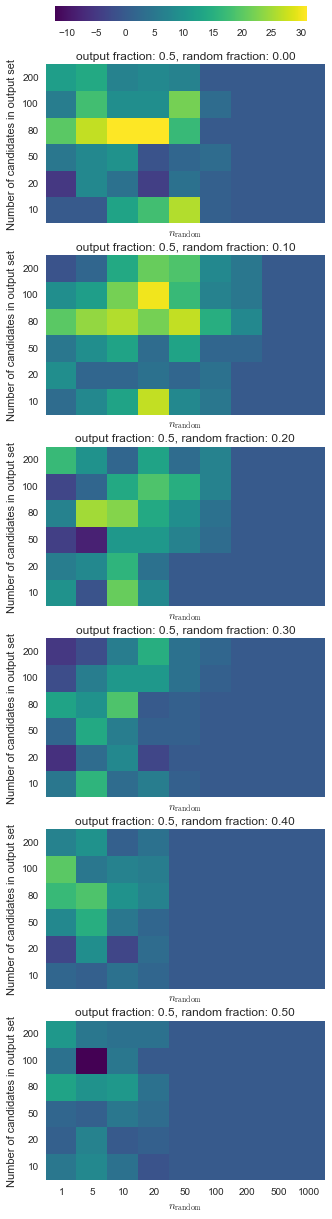

In [387]:
fig, axes = plt.subplots(len(y1),1,figsize=(5,20), sharey=True, sharex=True)

for i in range(0, len(y1), 1):
    tm1 = test_diff[:,:,i]
    
    ax1 = axes[i]
    im = ax1.pcolormesh(tm1, cmap=cmap.viridis,
                       vmin=vmin, vmax=vmax)
    ax1.set_xticks(np.arange(len(n_random))+0.5)
    ax1.set_xticklabels(n_random)

    ax1.set_xlabel(r"$n_\mathrm{random}$")
    ax1.set_yticks(np.arange(len(n_out))+0.5)
    ax1.set_yticklabels(n_out)

    ax1.set_ylabel("Number of candidates in output set")
    ax1.set_xlim(0,len(n_random))
    ax1.set_ylim(0, len(n_out))
    ax1.set_title("output fraction: 0.5, random fraction: %.2f"%y1[i])

cbar_ax = fig.add_axes([0.15, 0.93, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')



## Do repeated trials help with success?

Entrofy allows for the use of several trials (where the algorithm then picks the best solution) as a way of reducing some of the uncertainties in the single-trial experiments above. 

First, we'll pick a case where we've seen an appreciable number of failures:

In [314]:
n_out = [10, 20, 50, 80, 100, 200]

n_random = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

target_1 = [0.1, 0.2, 0.3, 0.4, 0.5]
target_2 = [0.1, 0.2, 0.3, 0.4, 0.5]

random_1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
random_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]



In [315]:
r = res["0.50"]

In [316]:
test_metric = r[:,:,-1,-1,1,-1,:]

In [317]:
test_metric_mask = test_metric != 0

In [318]:
test_metric_sum = np.sum(test_metric_mask, axis=2)

In [319]:
test_metric_sum.shape

(6, 9)

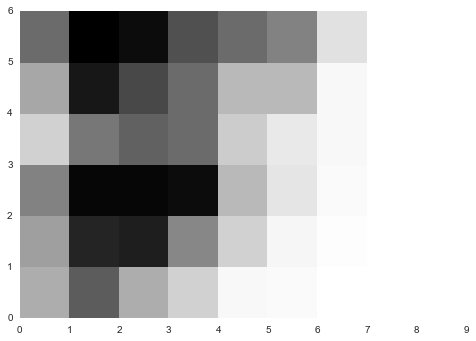

In [320]:
plt.pcolormesh(test_metric_sum)

In [256]:
np.max(test_metric_sum)

49

At least in one case, the algorithm fails 49 out of a hundred times for a single trial.
Let's pick that case:

In [259]:
test_ind = np.where(test_metric_sum == np.max(test_metric_sum))

test_n_out = n_out[test_ind[0]]
test_n_random = n_random[test_ind[1]]

print("Test case has n_out = %i"%test_n_out)
print("Test case has n_random = %i"%test_n_random)

Test case has n_out = 200
Test case has n_random = 5


We are now going to make simulations where we vary the number of trials used in entrofy:

In [397]:
r.shape

(6, 9, 5, 5, 6, 6, 100)

In [401]:
5*6*9*5*5*6*6*100

24300000

In [ ]:
test_metric = r[:,:,-1,-1,1,-1,:]

In [272]:
p1 = 0.5
p2 = 0.5

y1 = 0.1
y2 = 0.5

alpha = 0.5

ntrials = 20

sim, sim_mappers, sim_max_score = create_sim(p1, p2, y1, y2, n_out, n_random, alpha)

idx, max_score = entrofy.core.entrofy(sim, n_out, mappers=sim_mappers, alpha=alpha, n_trials=ntrials)

In [336]:
p1 = 0.5
p2 = 0.5

y1 = 0.0
y2 = 0.5

alpha = 0.5

nsims = 100

ntrials = [1, 2, 5, 10, 15, 20, 50, 100, 200]

scores = np.zeros((len(ntrials), nsims))


In [333]:
np.random.seed(20160629)
test_scores = []
for i in range(100):
    #print(alpha)
    sim, sim_mappers, sim_max_score = create_sim(0.5, 0.5, 0.1, 0.5, 
                                                 100, 5, alpha)
    #print(sim_max_score)
    idx, max_score = entrofy.core.entrofy(sim, 100, mappers=sim_mappers, 
                                          alpha=alpha, n_trials=1)
    test_scores.append(sim_max_score-max_score)
    #print(max_score)

In [334]:
test_scores = np.array(test_scores)
len(test_scores[test_scores>0])

50

In [337]:
for i,nt in enumerate(ntrials):
    print("Running for %i trials."%nt)
    for j in range(nsims):
        sim, sim_mappers, sim_max_score = create_sim(0.5, 0.5, 0.1, 0.5, 
                                                     100, 5, alpha)
        idx, max_score = entrofy.core.entrofy(sim, 100, mappers=sim_mappers, 
                                              alpha=alpha, n_trials=nt)
        
        scores[i,j] = sim_max_score - max_score

Running for 1 trials.
Running for 2 trials.
Running for 5 trials.
Running for 10 trials.
Running for 15 trials.
Running for 20 trials.
Running for 50 trials.
Running for 100 trials.
Running for 200 trials.


In [338]:
scores_mask = scores!=0.0
scores_sum = np.sum(scores_mask, axis=1)

In [339]:
scores_sum

array([43, 15,  3,  0,  0,  0,  0,  0,  0])

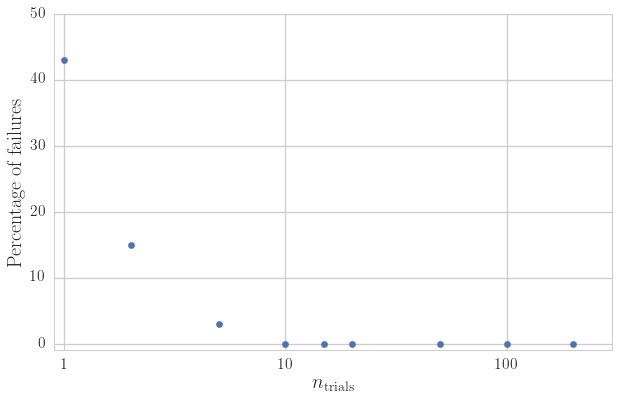

In [457]:

sns.set_context("talk", font_scale=1.2, rc={"axes.labelsize": 20})


plt.rc("font", size=20, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.scatter(ntrials, scores_sum, marker="o", color=sns.color_palette()[0], s=40)
ax.set_xscale("log")
ax.set_xlim(0.9, 300)
ax.set_ylim(-1, 50)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels(["1", "10", "100"])
ax.set_xlabel(r"$n_\mathrm{trials}$")
ax.set_ylabel("Percentage of failures")

plt.tight_layout()
plt.savefig("../data/f2.pdf", format="pdf")

# Conclusions

We performed several controlled experiments with simulated data sets to demonstrate that our algorithm can successfully recover a solution, i.e. an optimal set of participants embedded in a larger set of random data. We simulated a hypothetical data set of applicants with two categories, each of which comprises two attributes (denoted "yes" and "no"). We first simulated a single optimal solution to be planted in the data set based on a set of target fractions for each category, to ensure that an optimal solution could in principle be found in every simulation. The objective of these simulations was not to present realistic circumstances (where targe fractions are far from the properties of the input set and an optimal solution might not exist), but to explore situations where the algorithm fails when in principle, it should be able to find a solution. To each simulation, we then added a number of applicants with attributes that are randomly selected based on some (other) set of input fractions. These additional applicants effectively act as a type of noise. In realistic situations, ensembles of applicants might be imbalanced with respect to the target fractions; indeed, it might be a stated goal of the selection procedure to address imbalances. Hence we perform simulations with both data added to the solution with properties both similar and very dissimilar to the target fractions.
In addition, we varied both the number of participants in the solution set as well as the number of participants added as "noise". 

In summary, we vary target fractions between $0.1$ and $0.5$ (because our categories are binary, they are symmetric about $0.5$). We also vary fractions of additional random samples between $0.0$ and $0.5$, since it is in principle possible that members with a certain attributes exist only in the solution and not elsewhere. We vary the number of participants in the output set (i.e. the solution) between $10$ and $100$, since we deem it unlikely that the algorithm will be used for significantly larger data sets. We let the number of random samples added to the solution vary between $1$ and $1000$. We also varied the parameter $\alpha$ used in the objective function between $0.1$ and $1.0$. For each combination of parameters, we perform $100$ simulations, leading to a total of $24.3 \times 10^{6}$ simulations. 

For each simulation, we computed the value of the objective function for the solution embedded in the data, and then computed the difference between the solution found by \textit{entrofy} for this data set and the objective on the solution we embedded. Where this difference exceeds $0$, we deemed the solution found by \textit{entrofy} to be a failure: in this case, our method failed to find the optimal solution embedded or another solution as good.

In Figure \ref{fig:experiments1}, we present the results of our simulations. Here, we kept the target fractions as well as the random fractions (defining the properties of the randomly added applicants) of one category constant at $0.5$ and varied the target and random fractions of the other attribute to explore the effect both have on the solution. We find that the strongest failure mode occurs when the random fraction is $0.0$. In this case, the solution deliberately embedded in the data is the only set of participants yielding an acceptable value of the objective function. Because we use quantiles for tie-breaking when applicants have very similar attributes, this makes finding the optimal solution near-impossible when the set of applicants lacking the attribute in question is very large. Here, the algorithm will almost always fail on a single try, even if the target fraction of that attribute is as low as $0.1$. There appears a fairly sharp phase transition at $100$ random samples added to the output set, no matter the size of the output set. For random ensembles larger than that, the algorithm will fail nearly $100\%$ of the time. However, we caution the reader that the exact position of this phase transition is not well determined, since the grid used in exploring parameter is fairly coarse (and uses steps of either $0.1$ or $10$ for almost all parameters). 

When the random fraction is not $0$, the rate of failure is lowest when it matches the target fractions, and highest when random and target fractions are most dissimilar. In all cases, failure rates are $<50\%$ on a single run of \textit{entrofy} on a given data set, and failure rates are higher when the size of the random sample added to the solution is small compared to the size of the target output set. This, too, is related to the number of equally optimal solutions in the data set: when the size of the random sample added to the solution is large, and random and target fractions are not too dissimilar, there will be a number of possible solutions, and the probability of the algorithm finding one of them is comparatively large. Conversely, when there are only few samples added to the solution embedded in the data, that solution is likely the only acceptable participant set for \textit{entrofy} to find, and it will be less probable that the algorithm finds exactly that solution. As expected, this effect is exacerbated if the properties of the random sample and the target fractions differ strongly.

The behaviour described above is largely independent of the parameter $\alpha$. For $\alpha$ between $0.1$ and $0.5$, the results from the simulations are largely consistent. Only when $\alpha = 1$, the failure rate increases significantly, overall by about $5$ failures for each combination of parameters. This is expected, since $\alpha$ changes the shape of the objective function in a way that will make it slightly harder for the algorithm to find the optimal solution when $\alpha = 1$. Thus, we recommend $\alpha = 0.5$ as a reasonable value reliably returning optimal solutions.

In practice, running \textit{entrofy} several times on the same data set and choosing the solution with the maximum value of the objective function is a simple way to mitigate failures on single runs. While this increases runtime, the additional computational cost is small enough on all reasonable data sets (up to at least $1500$ candidates in the input set) to merit the increase in accuracy.
This is implemented in \textit{entrofy} as the parameters `ntrials`, allowing the user to straightforwardly choose the number of trials for entrofy to run and return the best solution it found. In order to test how many simulations are generally necessary to make success highly probable, we picked a case where nearly half of the simulations failed and tested for success as a dependence of the `ntrials` parameter. We chose a case with an output set of $100$ participants and target fractions of $0.5$ for each attribute in both categories. Again, we simulated a solution with these parameters, and then added $5$ additional candidates to the set distributed with one attribute split $0.1$ ("yes") and $0.9$ ("no"), the other $0.5$ for "yes" and "no" both. In our original simulations with $\alpha = 0.5$, this lead to $49$ failures, the highest rate of failure in simulations with this particular combination of target and random fractions. As described above, we compute the objective function for each embedded solution, and subsequently compare with the score returned by \textit{entrofy}. In this experiment, however, we vary the number of trials used in \textit{entrofy} for computing the objective score, between $1$ and $200$, and run $100$ simulations for each value of `ntrials`. In Figure \ref{fig:experiments2}, we present the results of these simulations. Consistent with our previous results, nearly half of the \textit{entrofy} runs fail to find the optimal solution when the algorithm is run only once. As soon as multiple trials are used, however, the failure rate drops sharply and reaches $0$ at around $10$ iterations. Thus, in general, allowing \textit{entrofy} to run $\sim 10$ times and report the best out of those runs will allow the optimal solution to be found, if one is present in the data.

